#### Modelo XGBoost

In [1]:
# Bibliotecas principais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import seaborn as sns

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
)
from sklearn.linear_model import LogisticRegression

In [2]:
# carregando o dataset
df_mkt = pd.read_csv('../Data/Projetos_para_Treinamento.csv')

In [3]:
df_mkt.head(1)

,projeto,produto,tipo,tema,clima,investimento,alcance,engajamento,sentimento,edicao_repetida,resultado_anterior,inovacao,sucesso
0,Carnaval 2024,CARNA2024,Evento,Festivo,ensolarado,40000.0,15000.0,20000.0,neutro,Sim,bom,2.0,Sim


In [4]:
df_mkt.shape

(150, 13)

In [5]:
df_mkt.dtypes

projeto                object
produto                object
tipo                   object
tema                   object
clima                  object
investimento          float64
alcance               float64
engajamento           float64
sentimento             object
edicao_repetida        object
resultado_anterior     object
inovacao              float64
sucesso                object
dtype: object

In [6]:
df_mkt.isnull().sum()

projeto               0
produto               0
tipo                  0
tema                  0
clima                 0
investimento          0
alcance               0
engajamento           0
sentimento            0
edicao_repetida       0
resultado_anterior    0
inovacao              0
sucesso               0
dtype: int64

In [7]:
# Verificar duplicatas no df_train
duplicados = df_mkt.duplicated()

# Contar quantas linhas duplicadas existem (exceto a primeira ocorrência)
num_duplicados = duplicados.sum()

print(f"Número de linhas duplicadas: {num_duplicados}")

Número de linhas duplicadas: 0


In [8]:
# Quantidade de dados distribuidos
print(df_mkt.columns)

Index(['projeto', 'produto', 'tipo', 'tema', 'clima', 'investimento',
       'alcance', 'engajamento', 'sentimento', 'edicao_repetida',
       'resultado_anterior', 'inovacao', 'sucesso'],
      dtype='object')


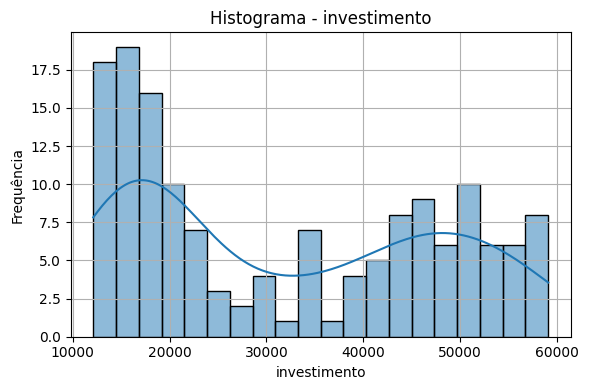

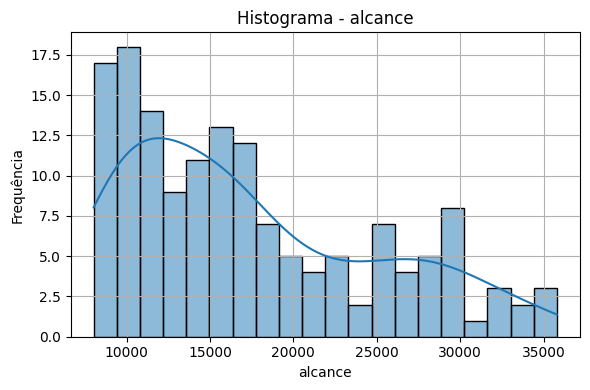

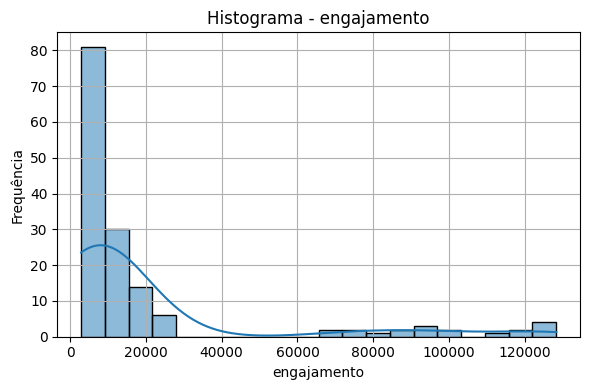

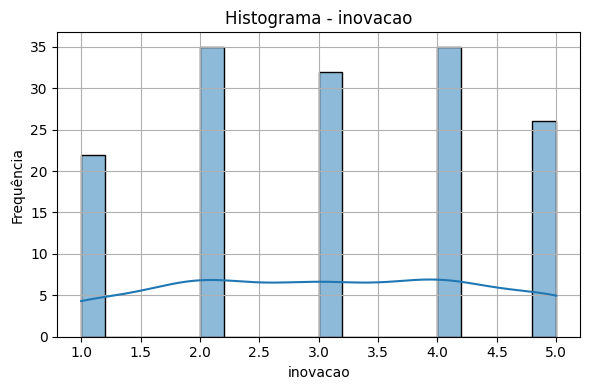

In [9]:
# Separar colunas numéricas e categóricas
num_cols = df_mkt.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df_mkt.select_dtypes(include=['object', 'category', 'bool']).columns

# Plotar histogramas para variáveis numéricas
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df_mkt[col], kde=True, bins=20)
    plt.title(f'Histograma - {col}')
    plt.xlabel(col)
    plt.ylabel('Frequência')
    plt.grid(True)
    plt.tight_layout()
    plt.show()



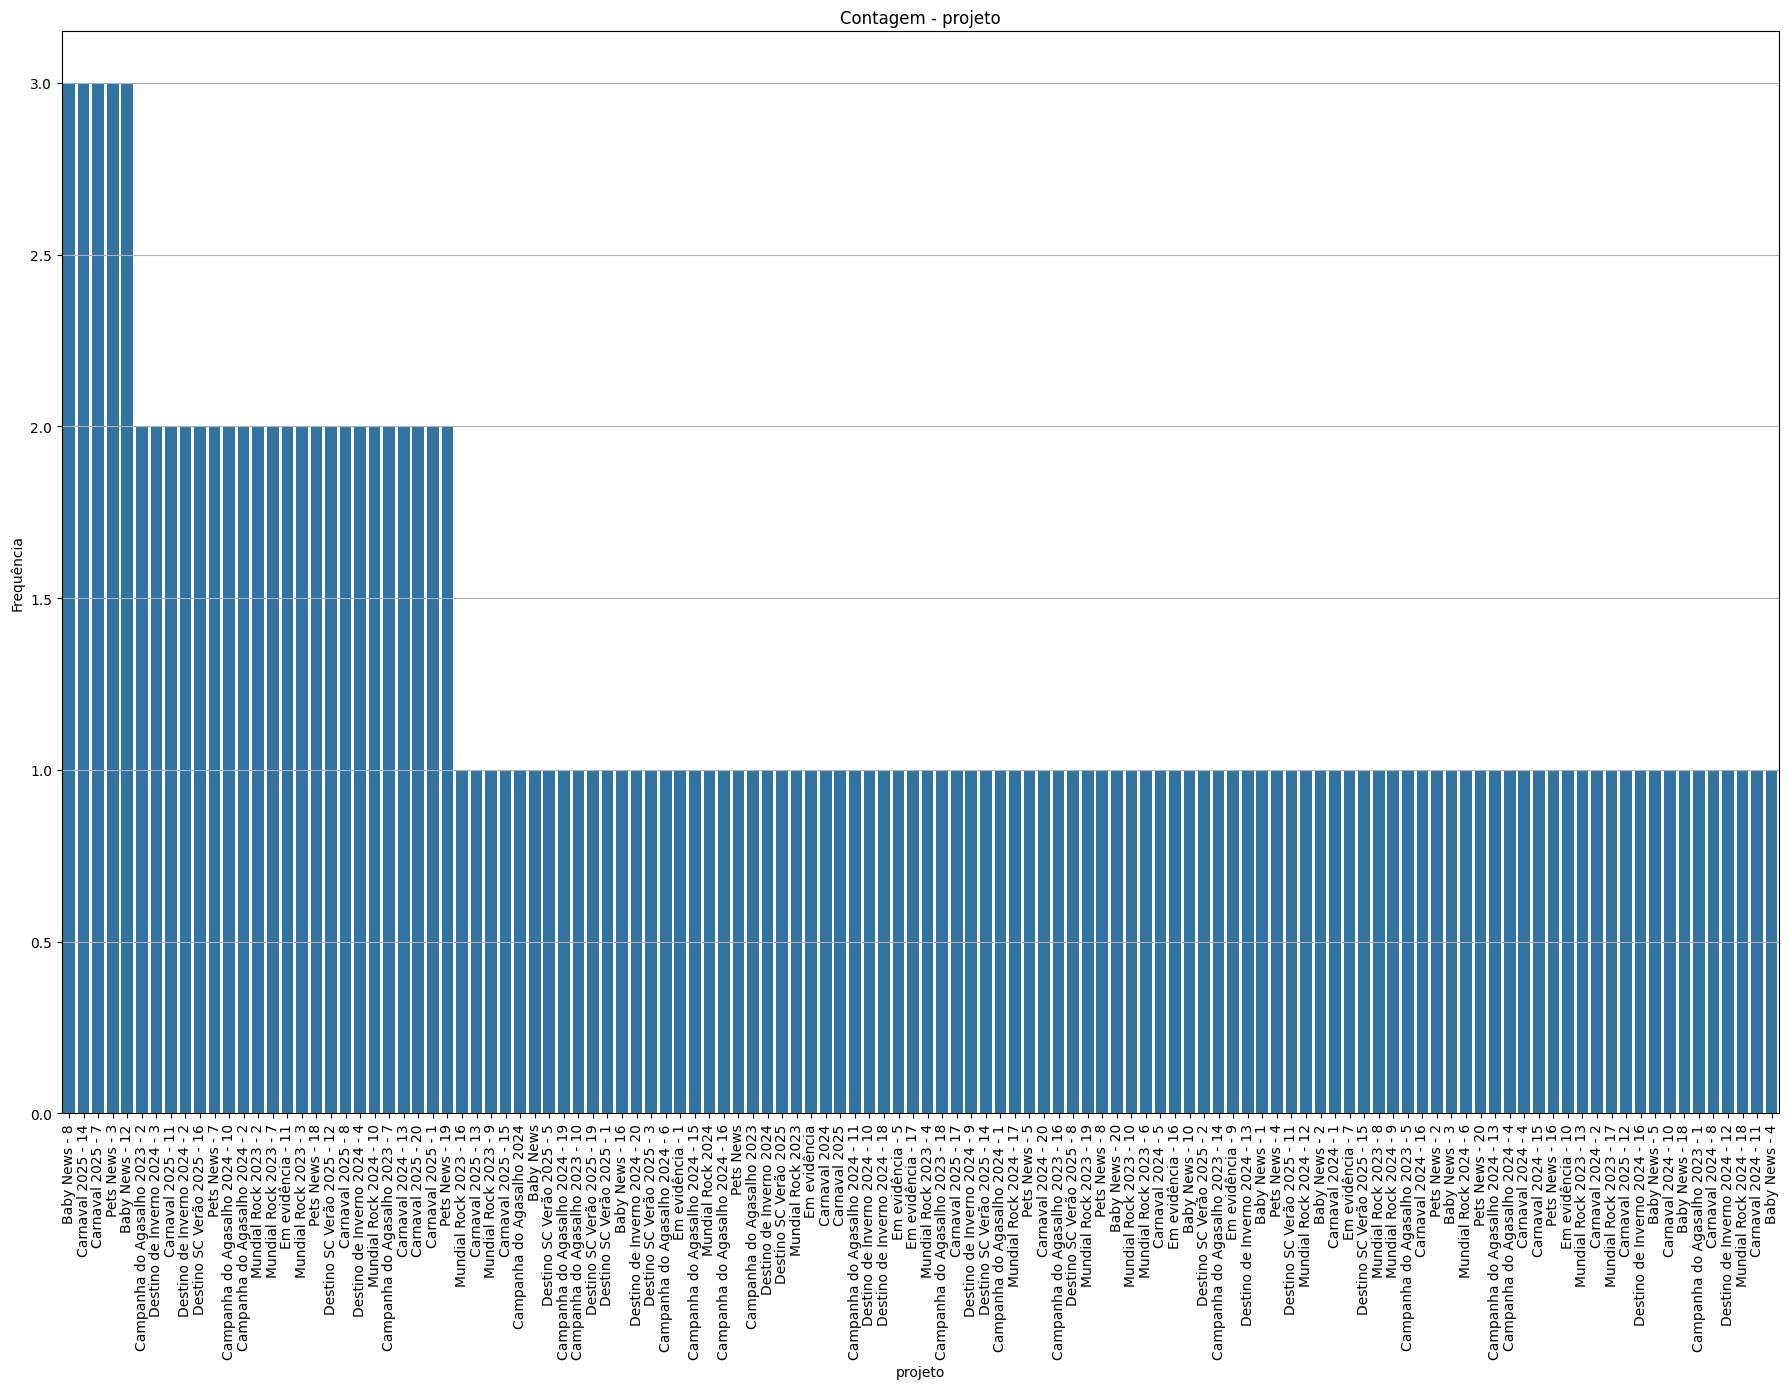

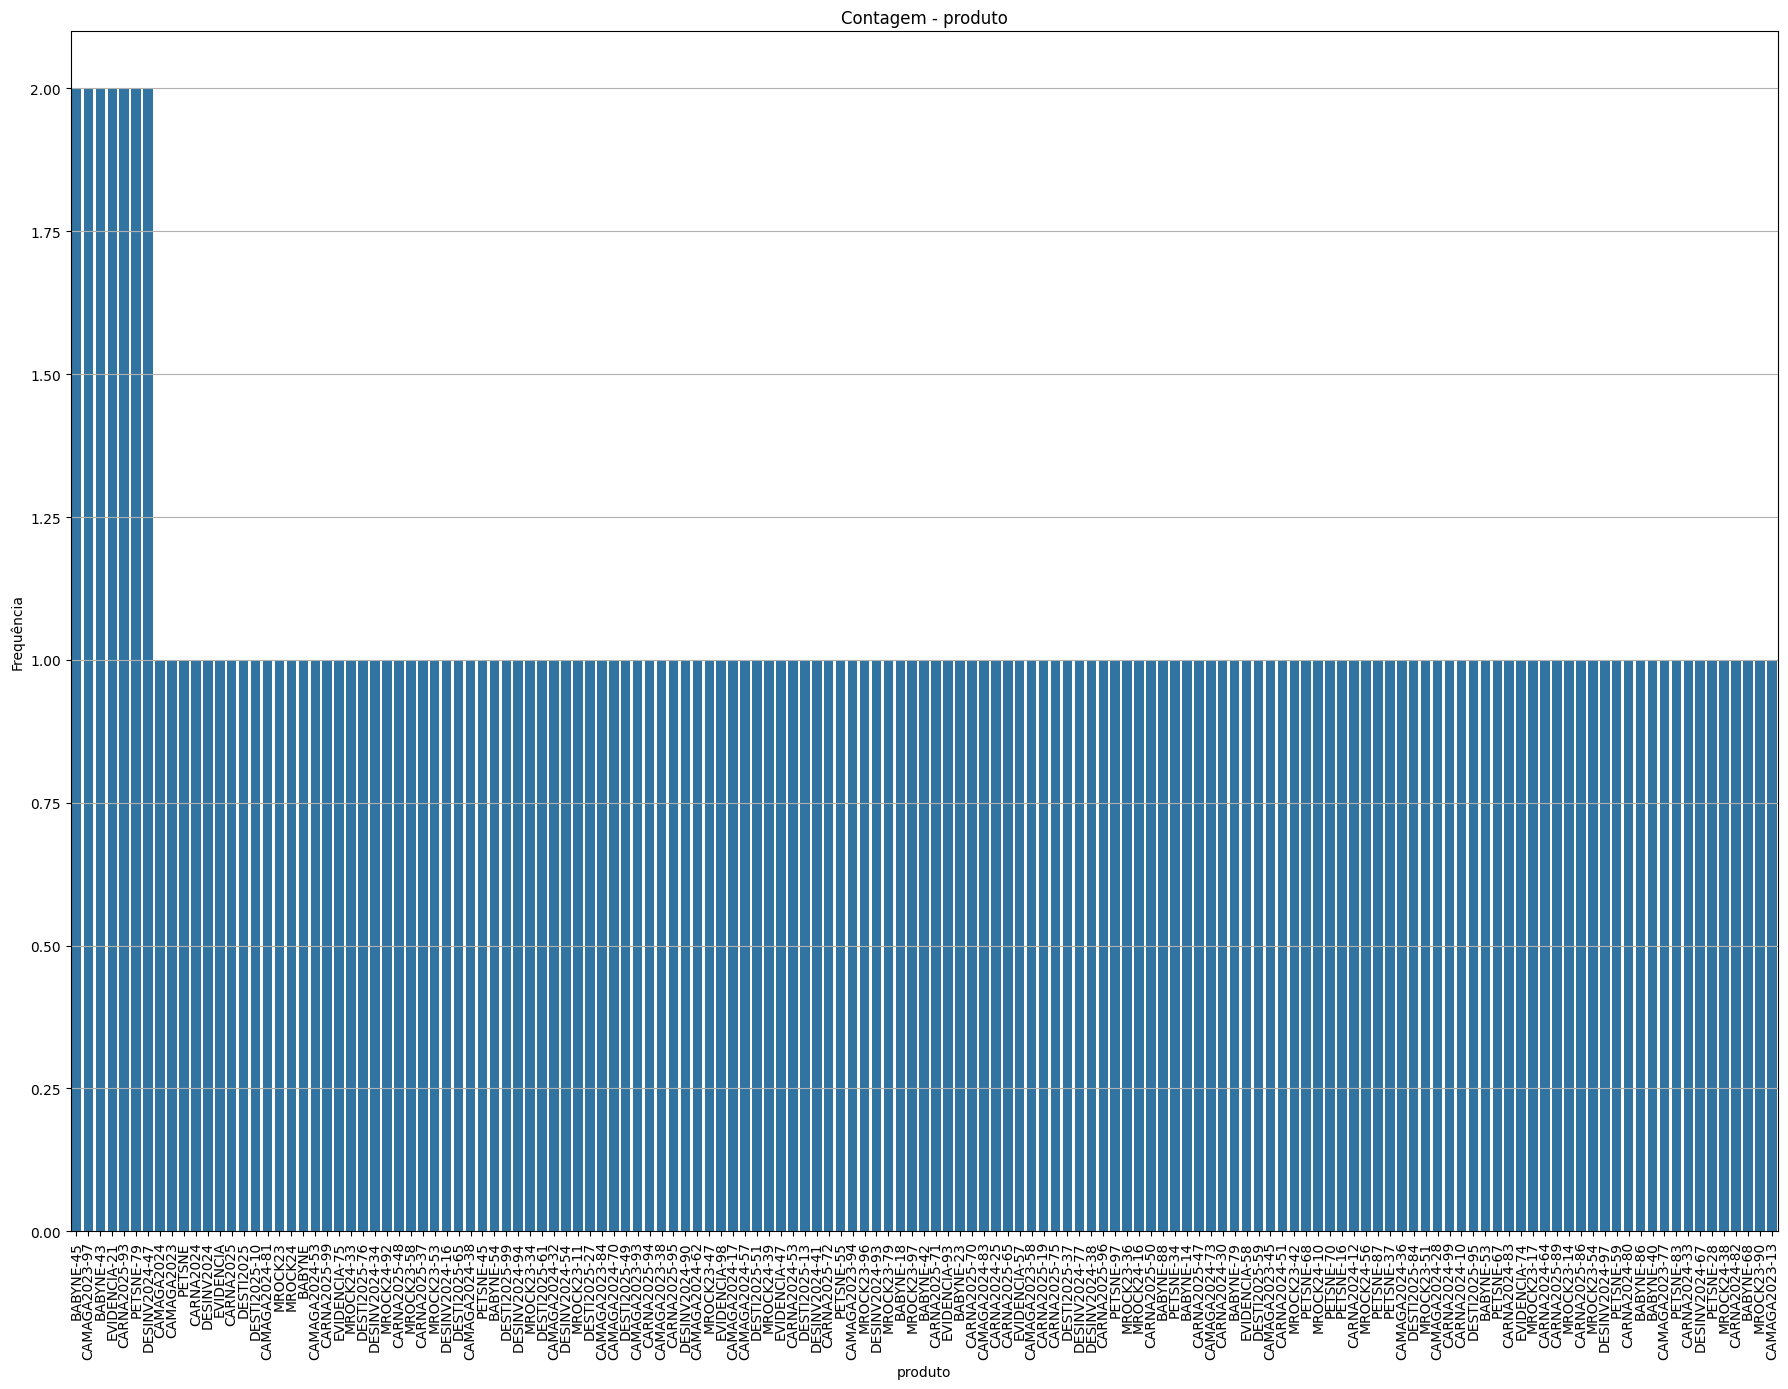

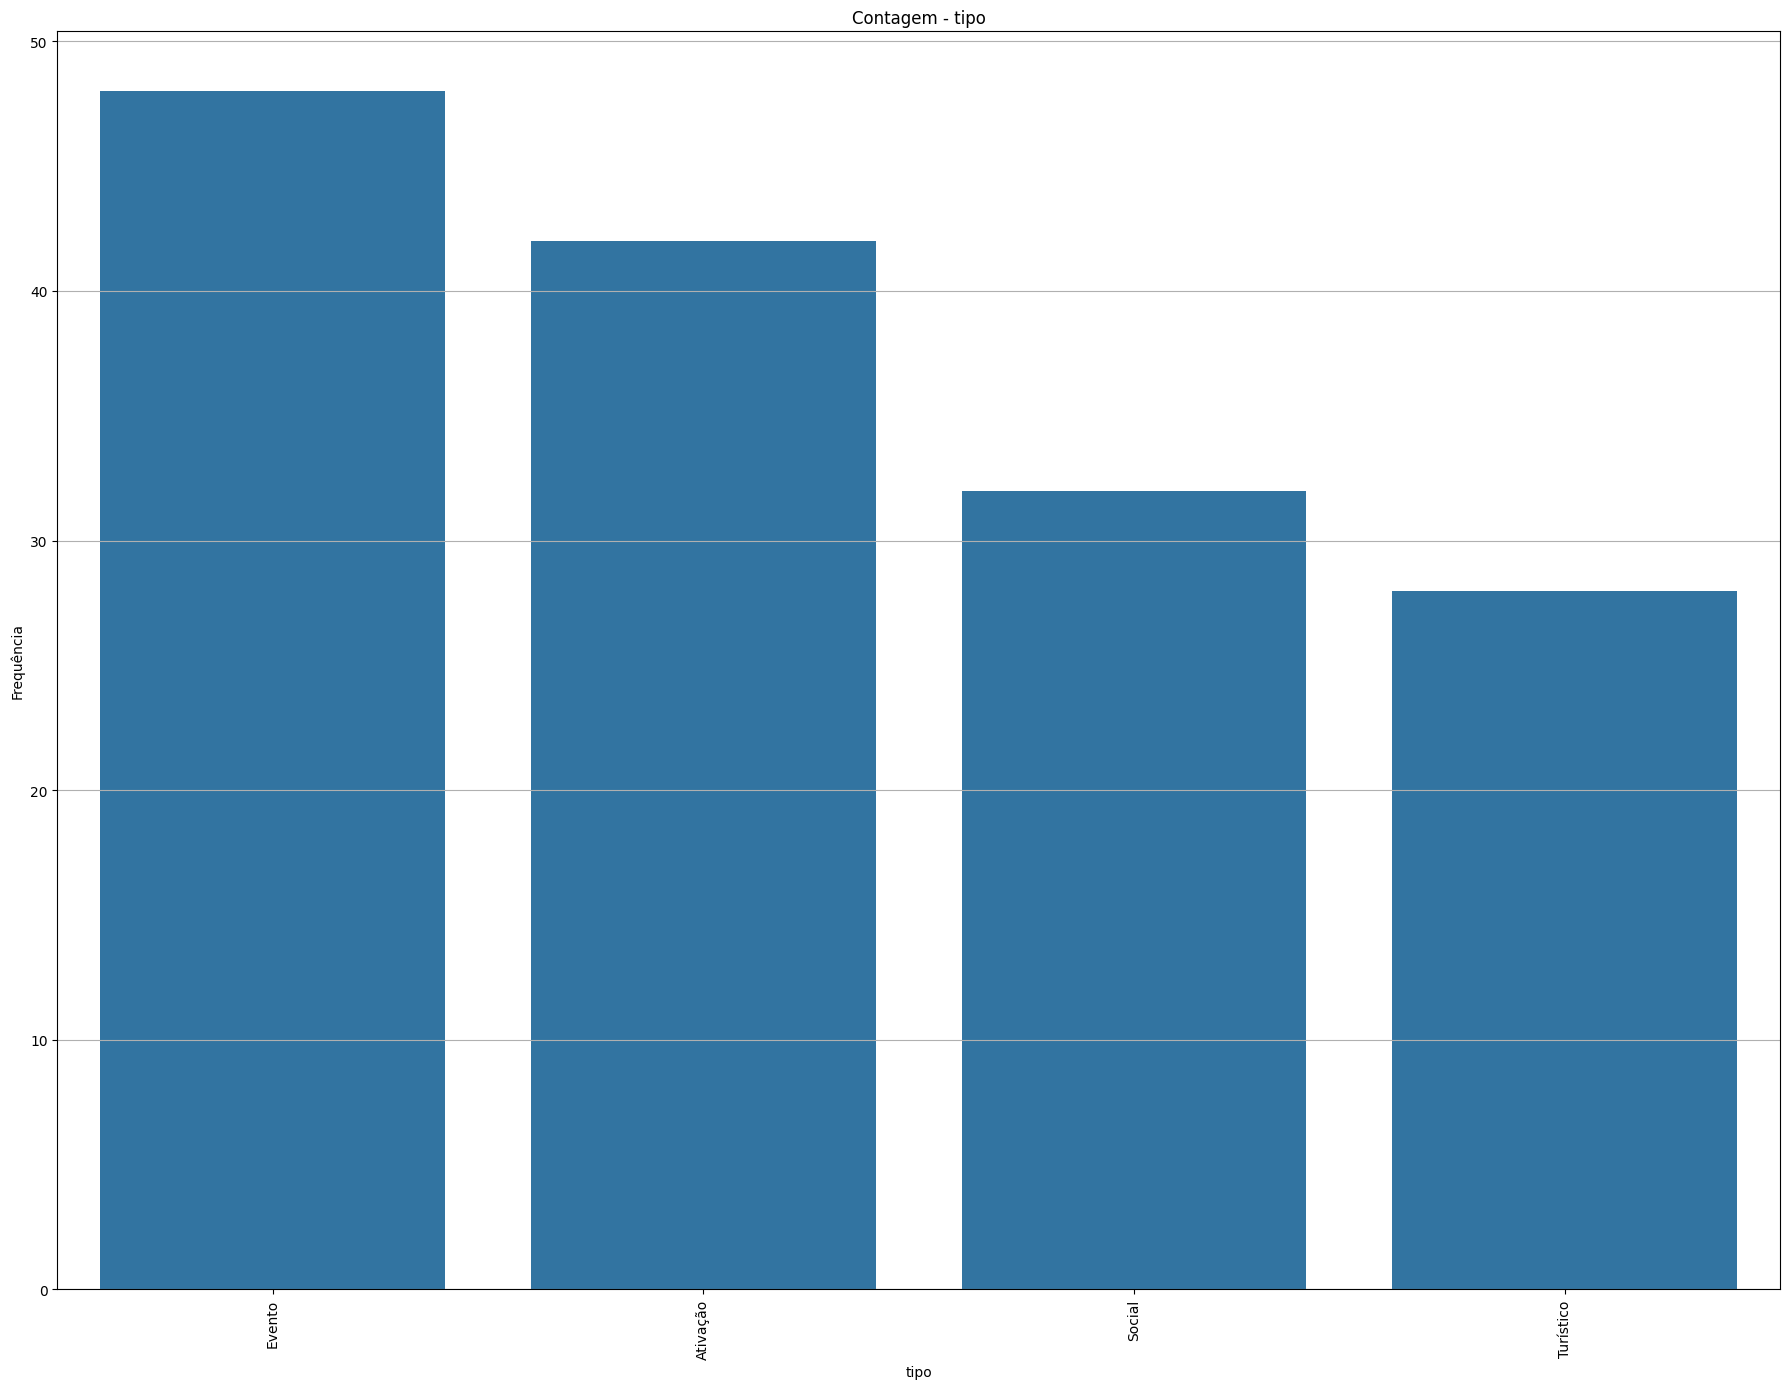

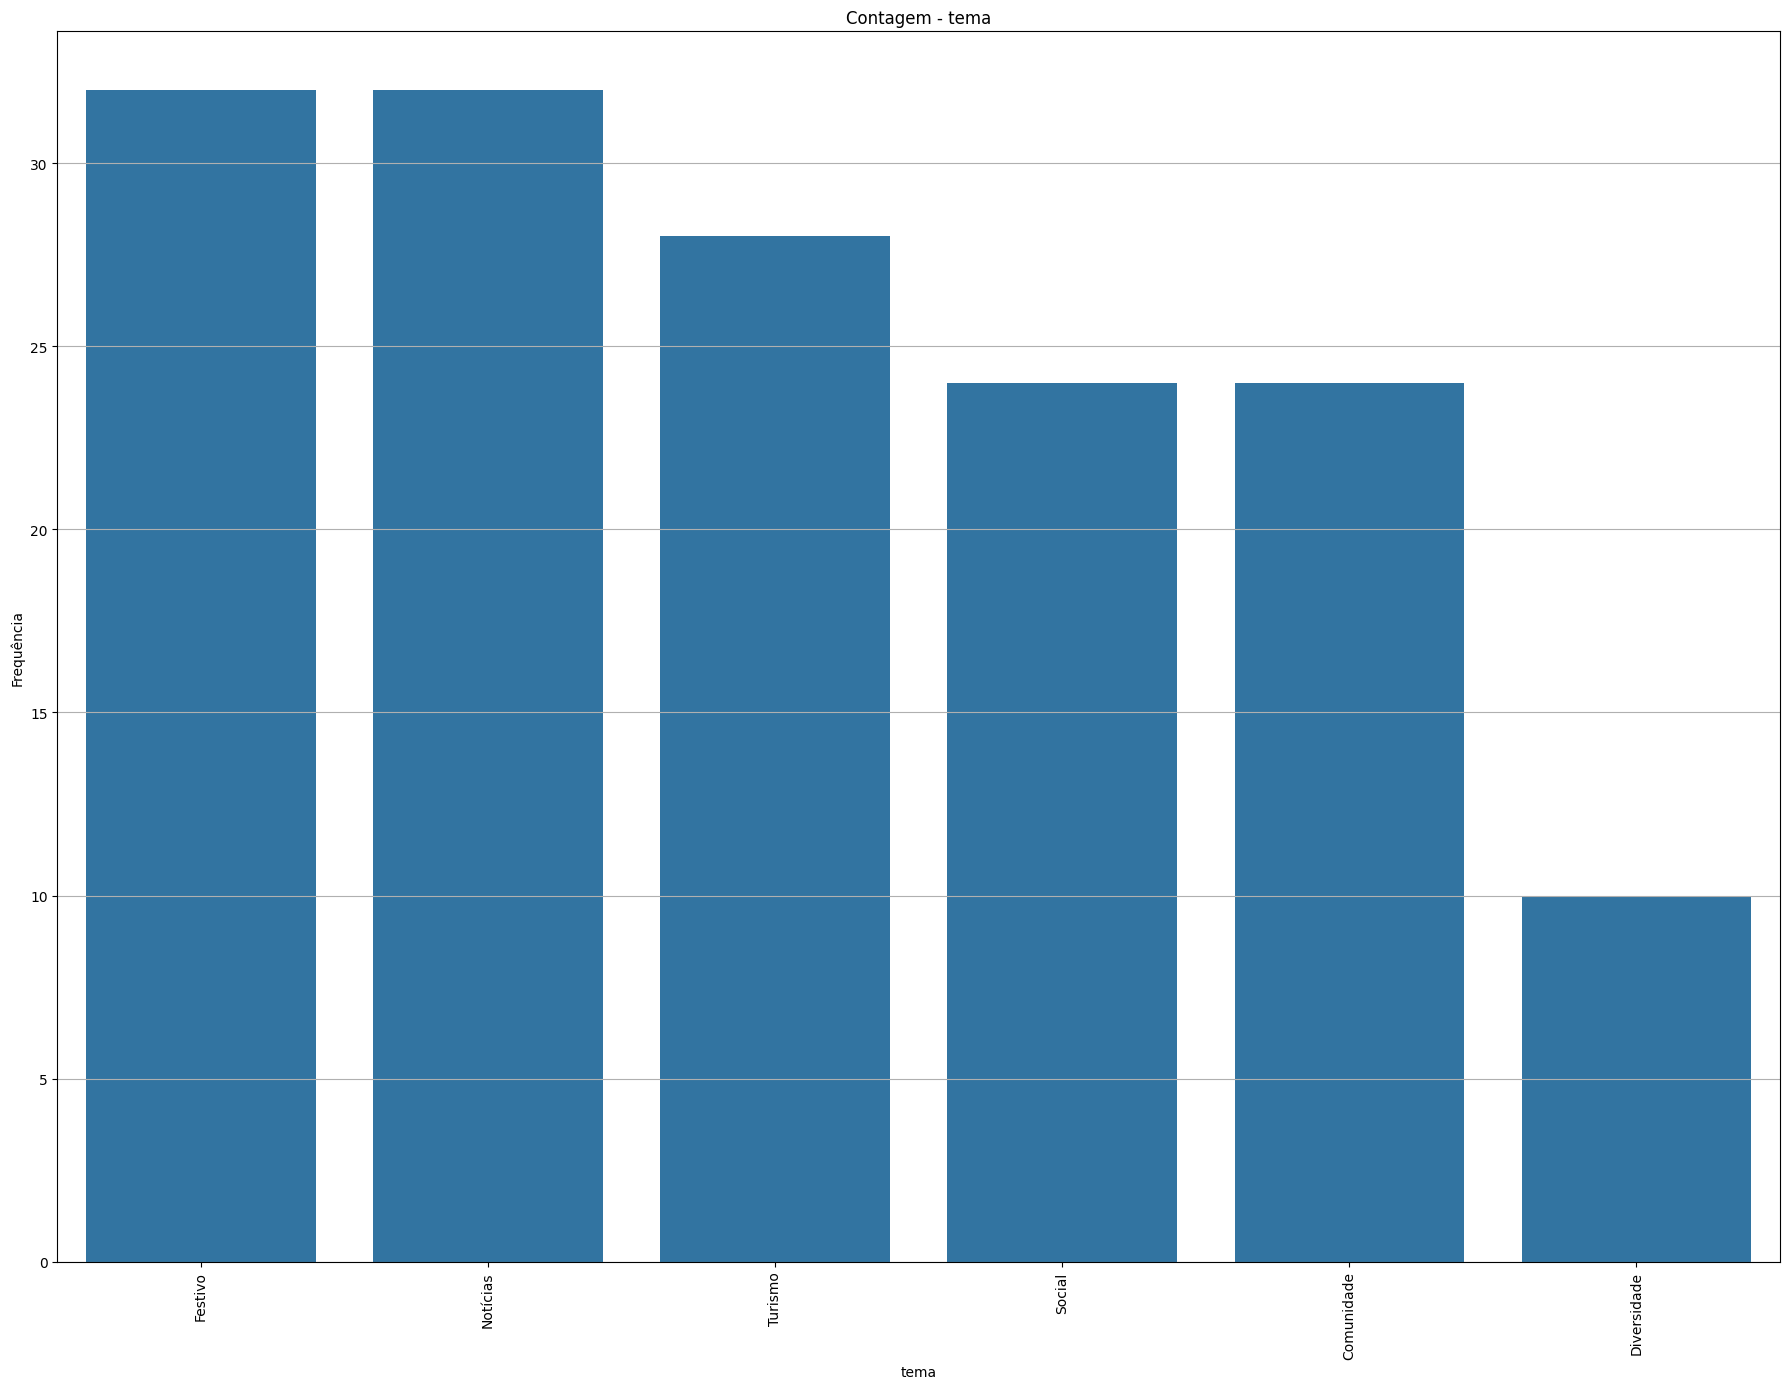

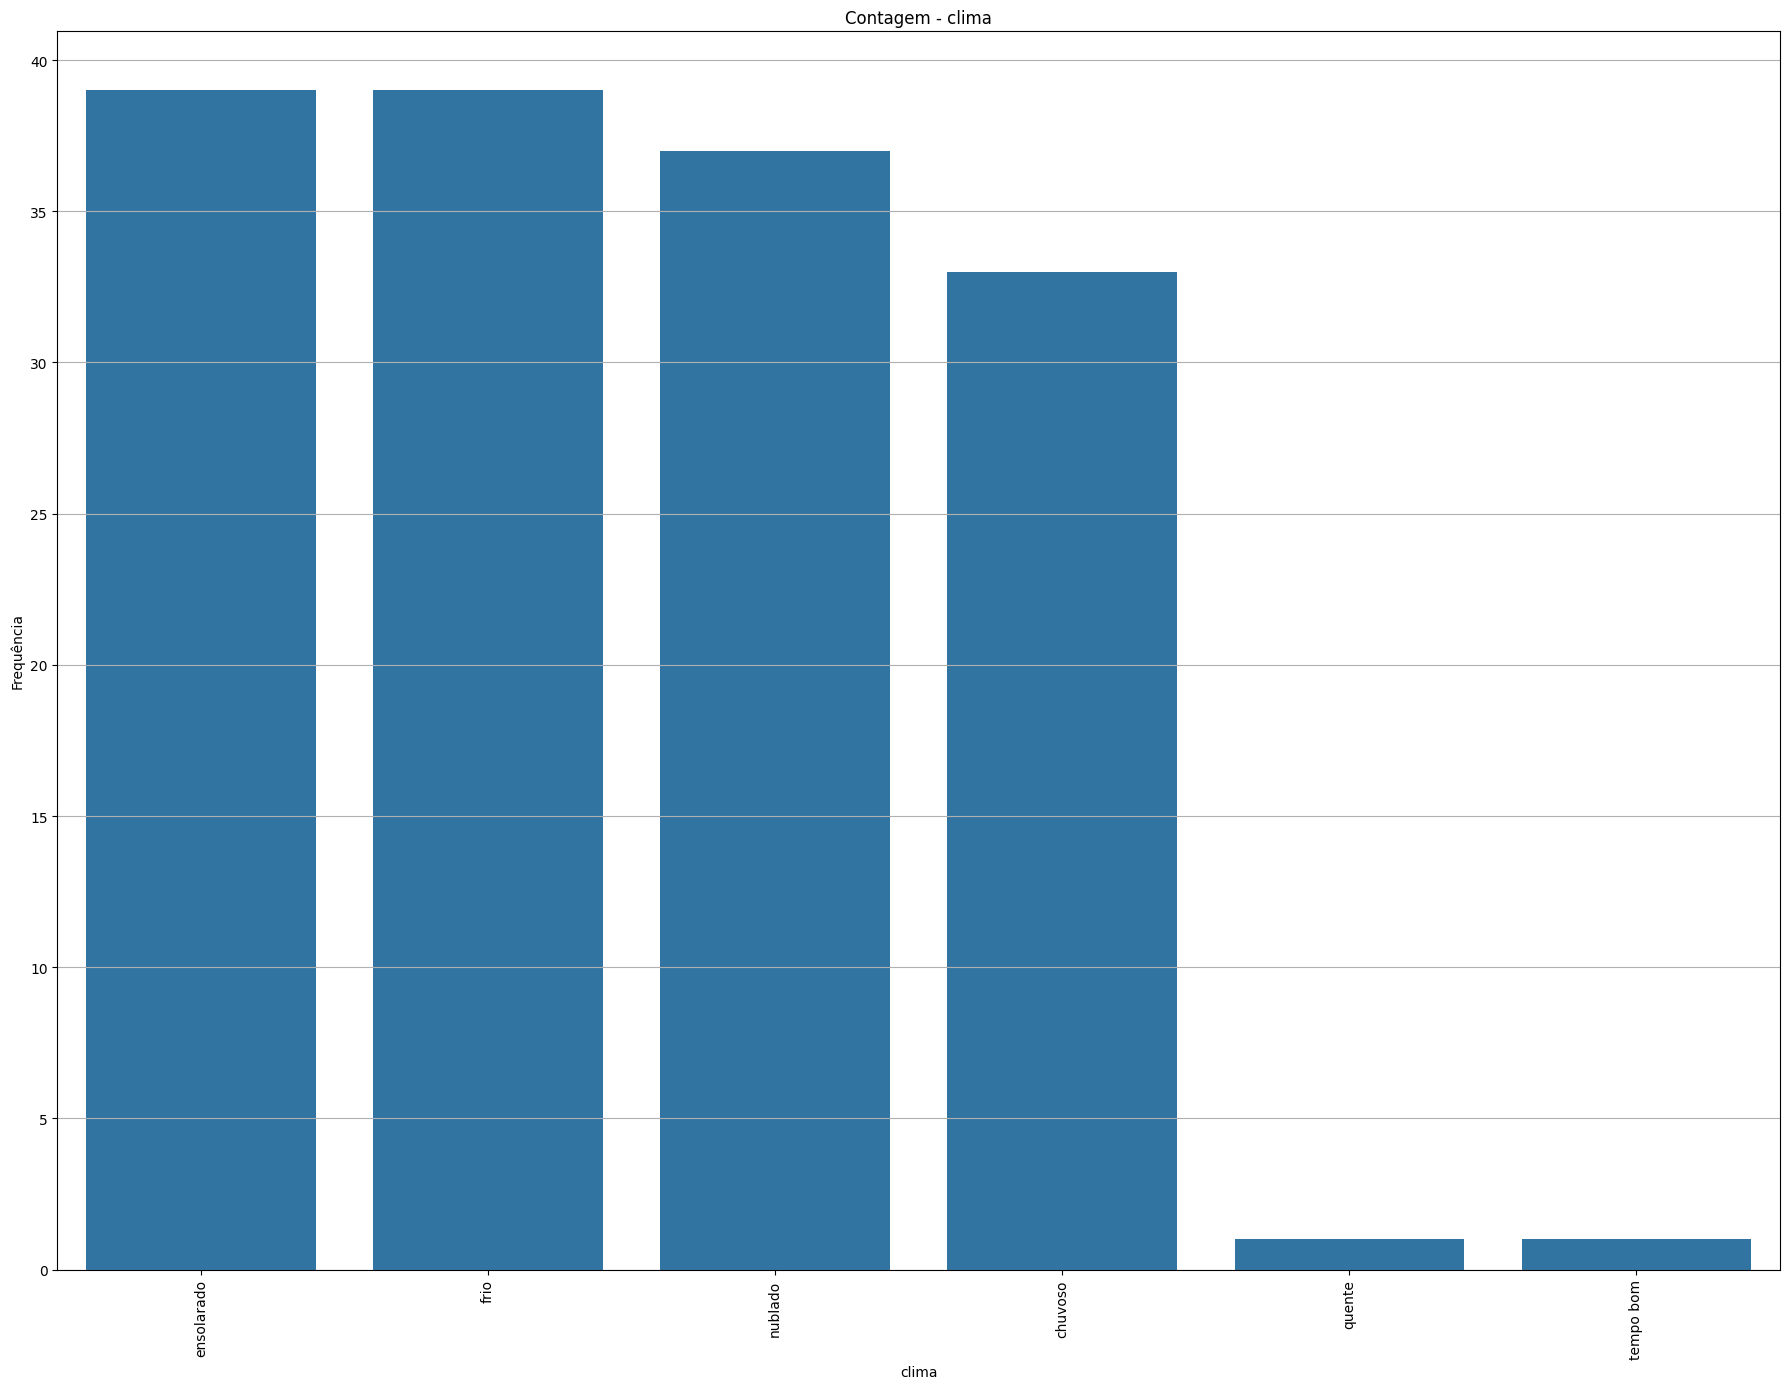

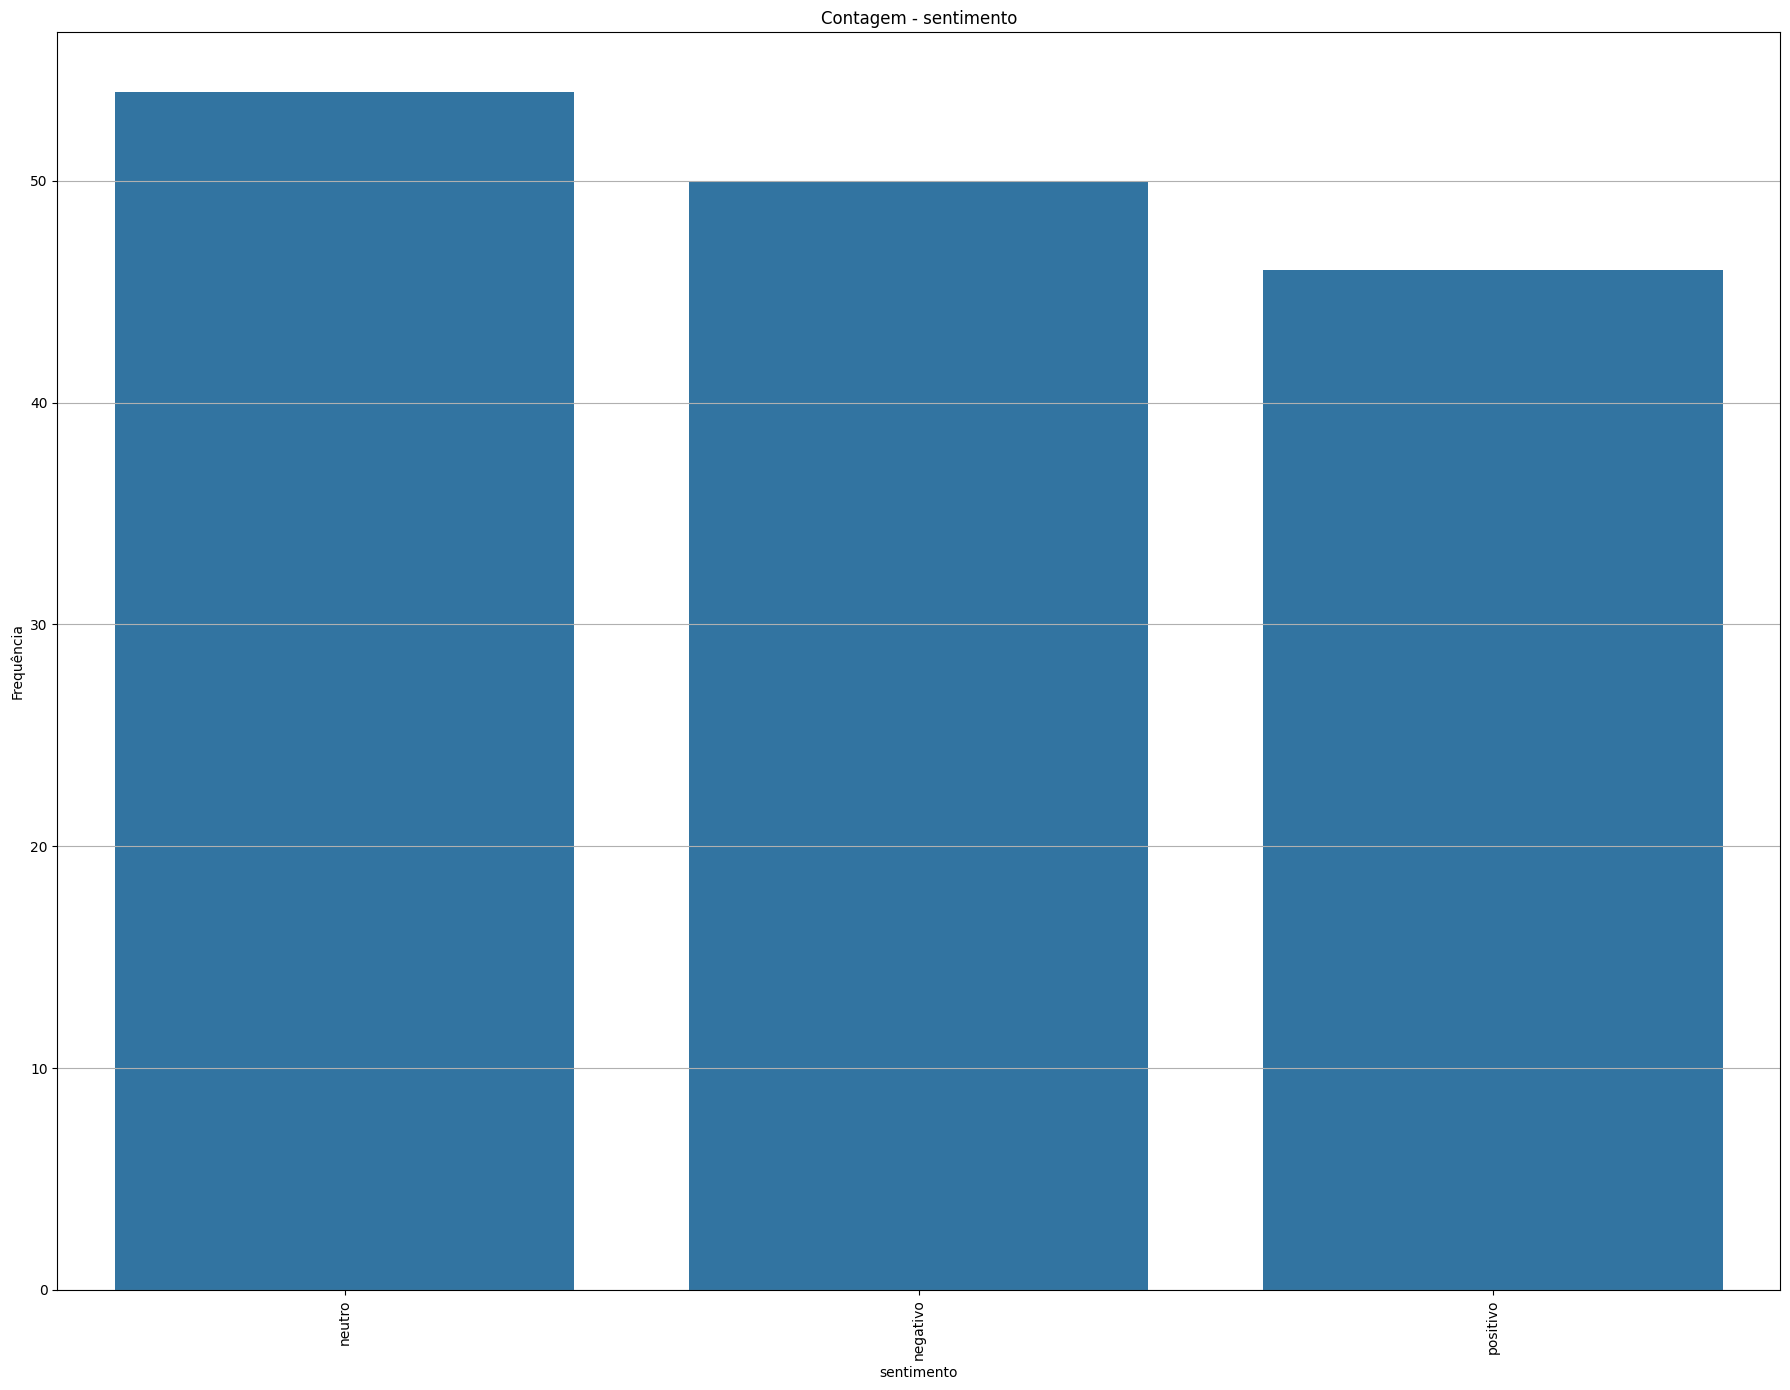

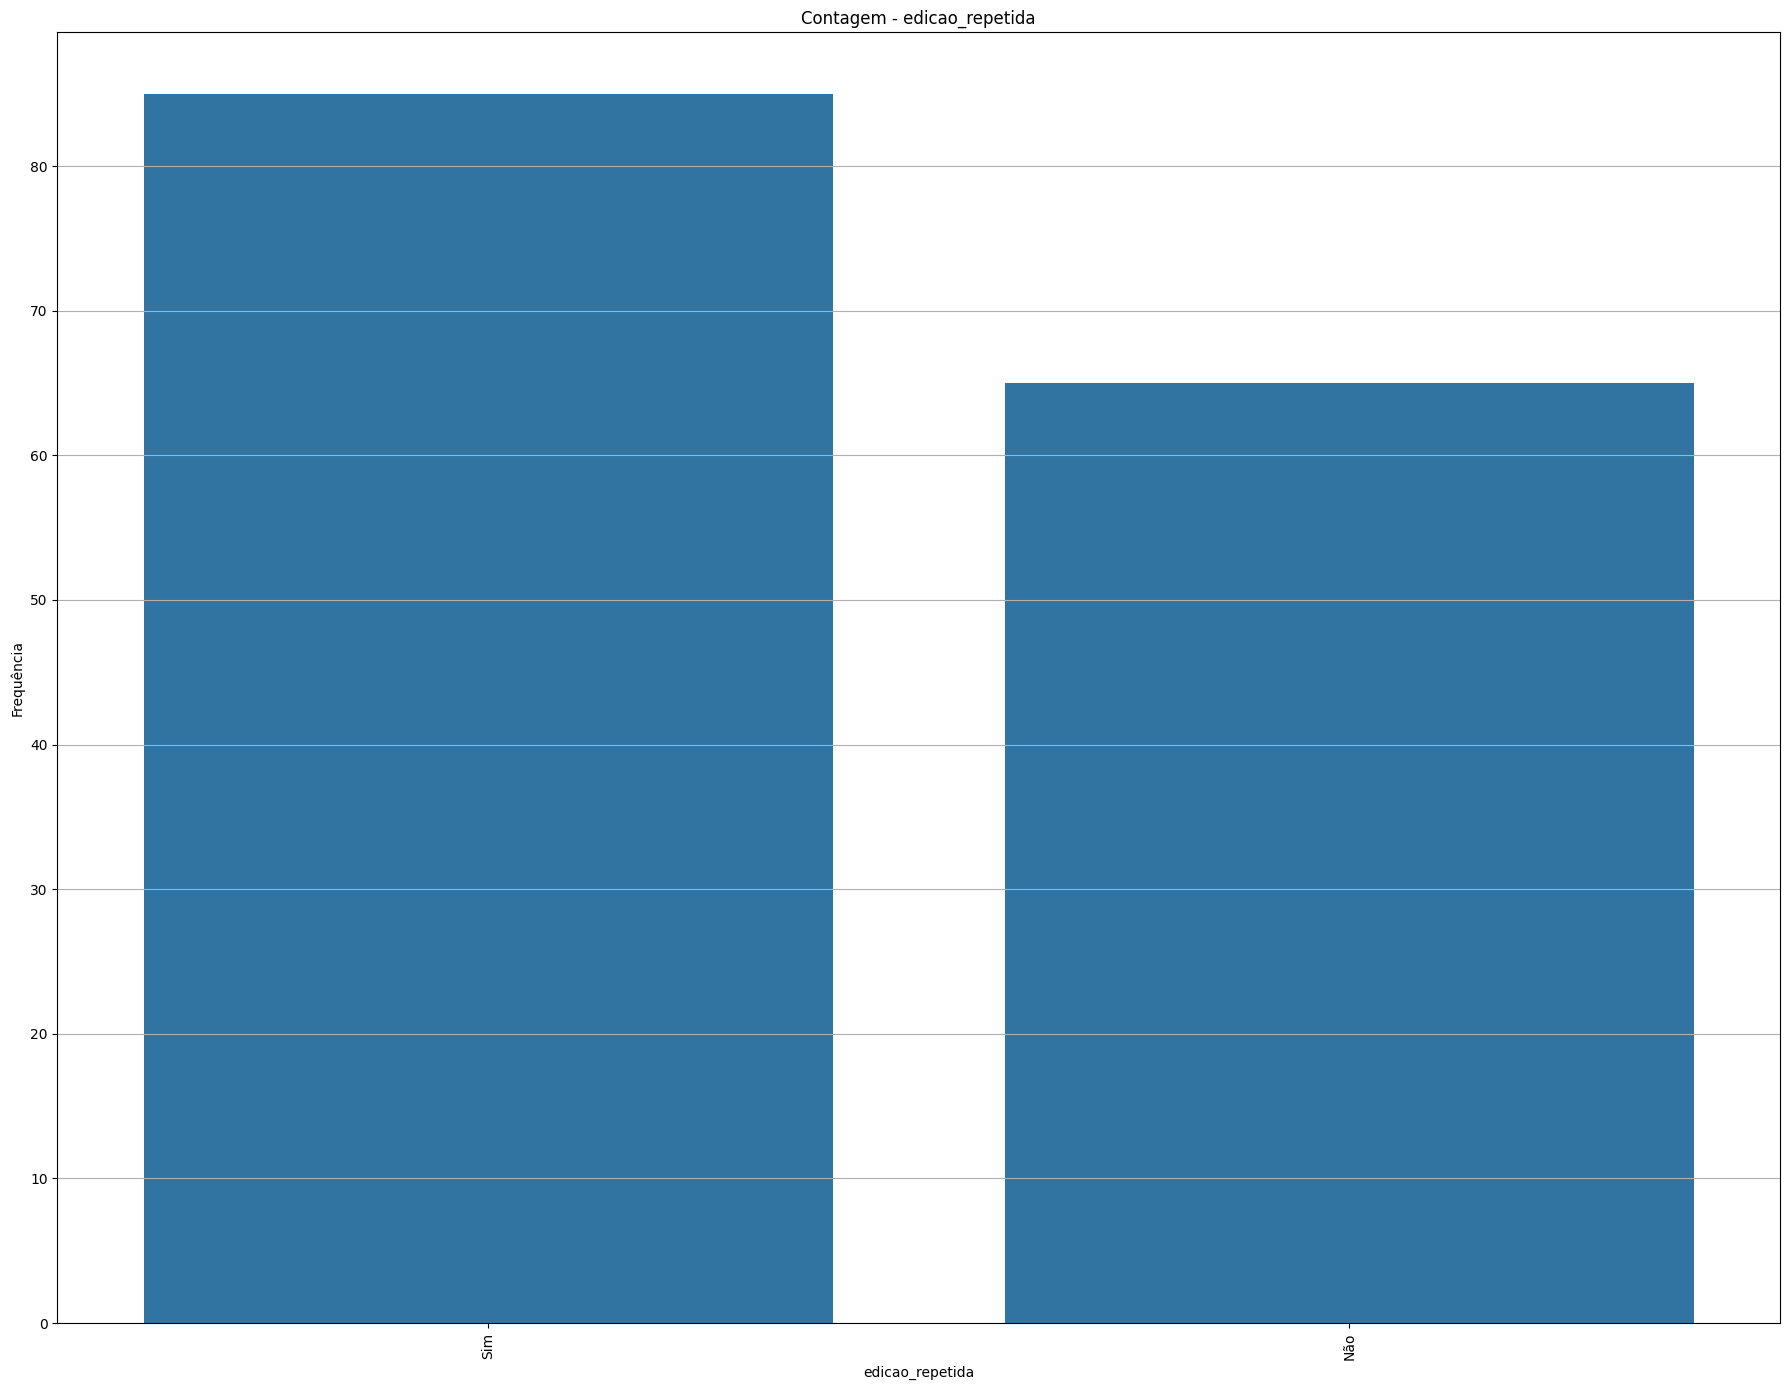

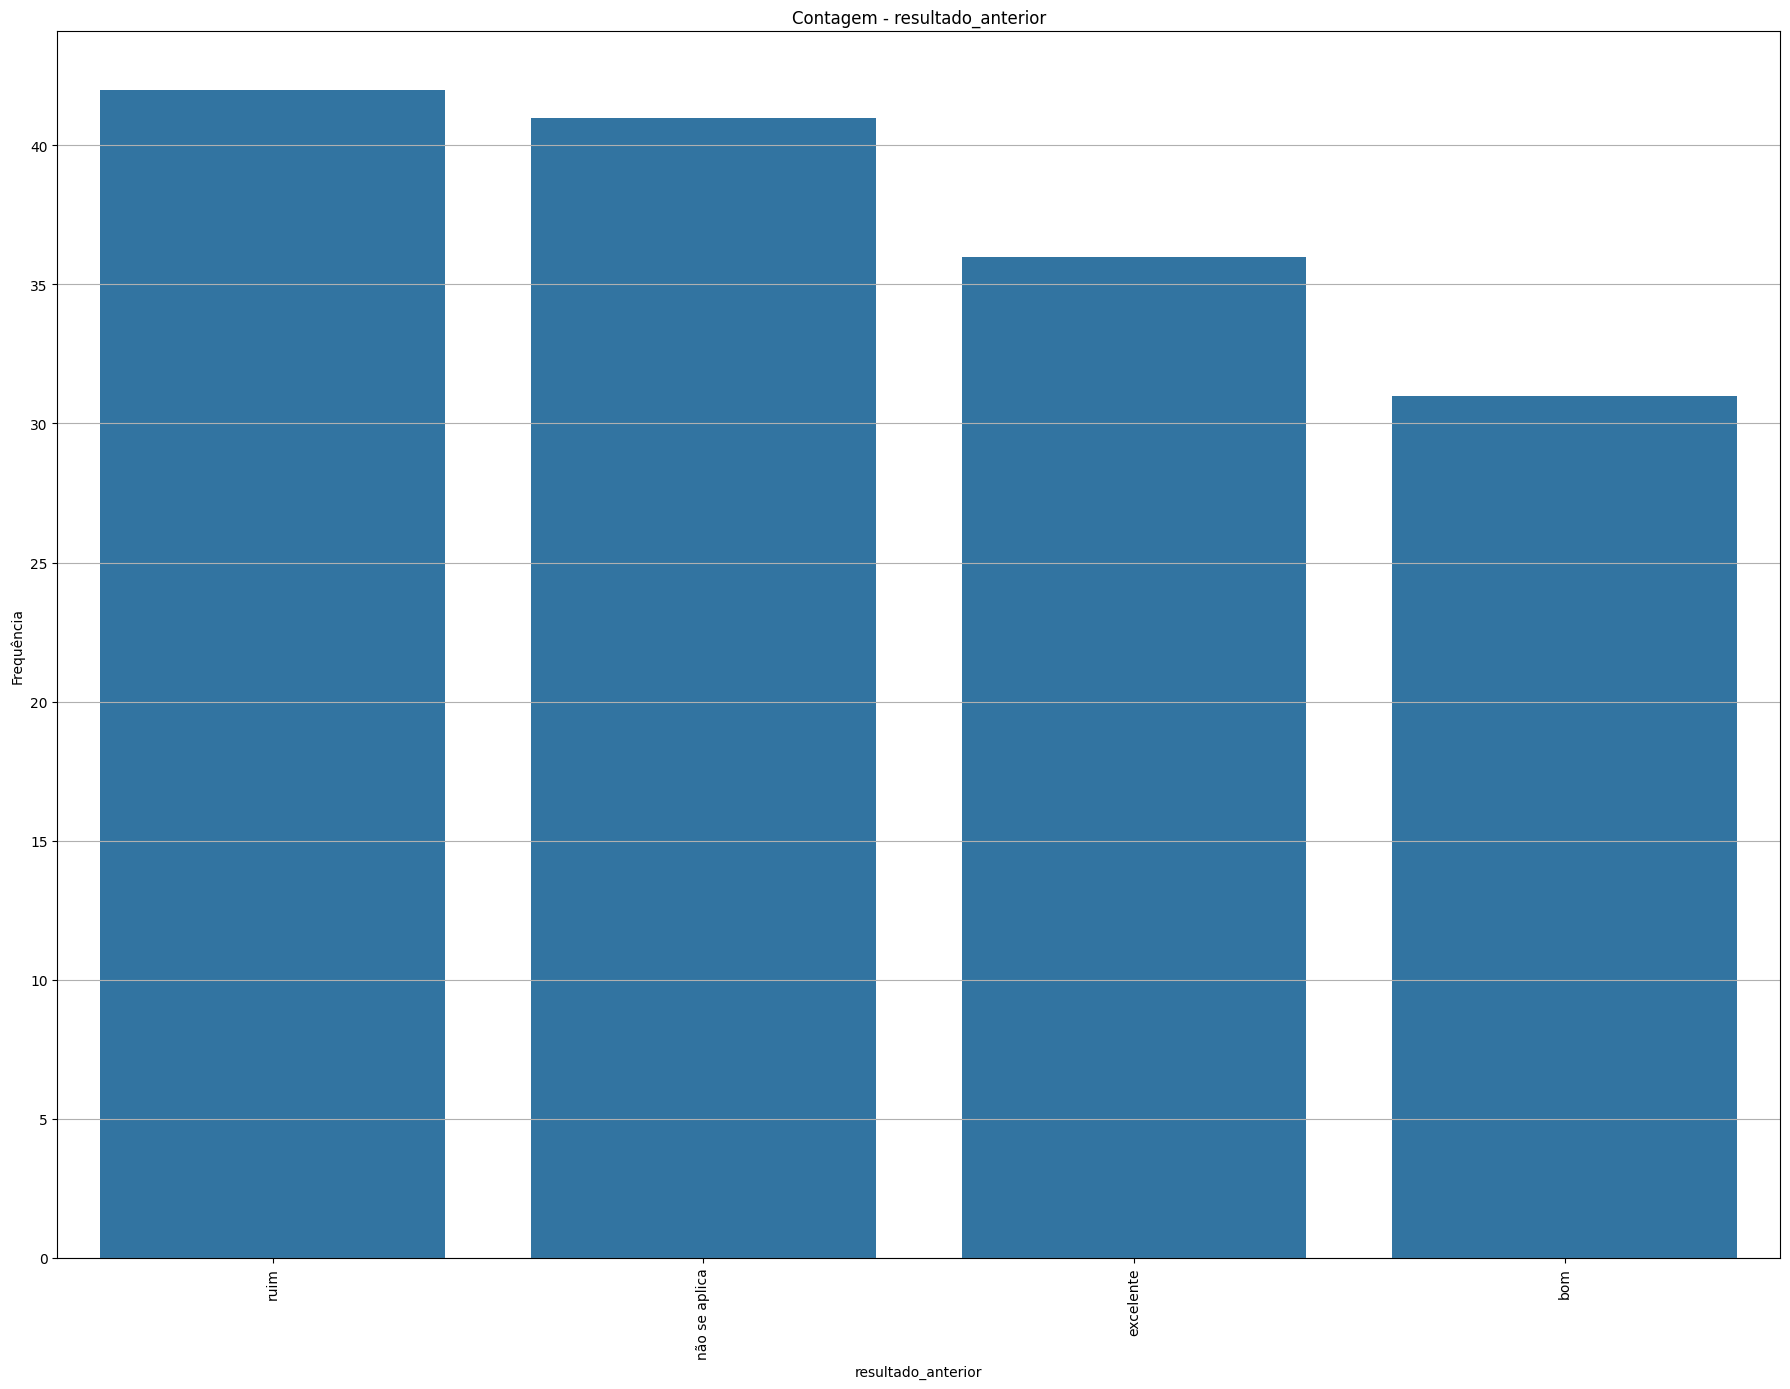

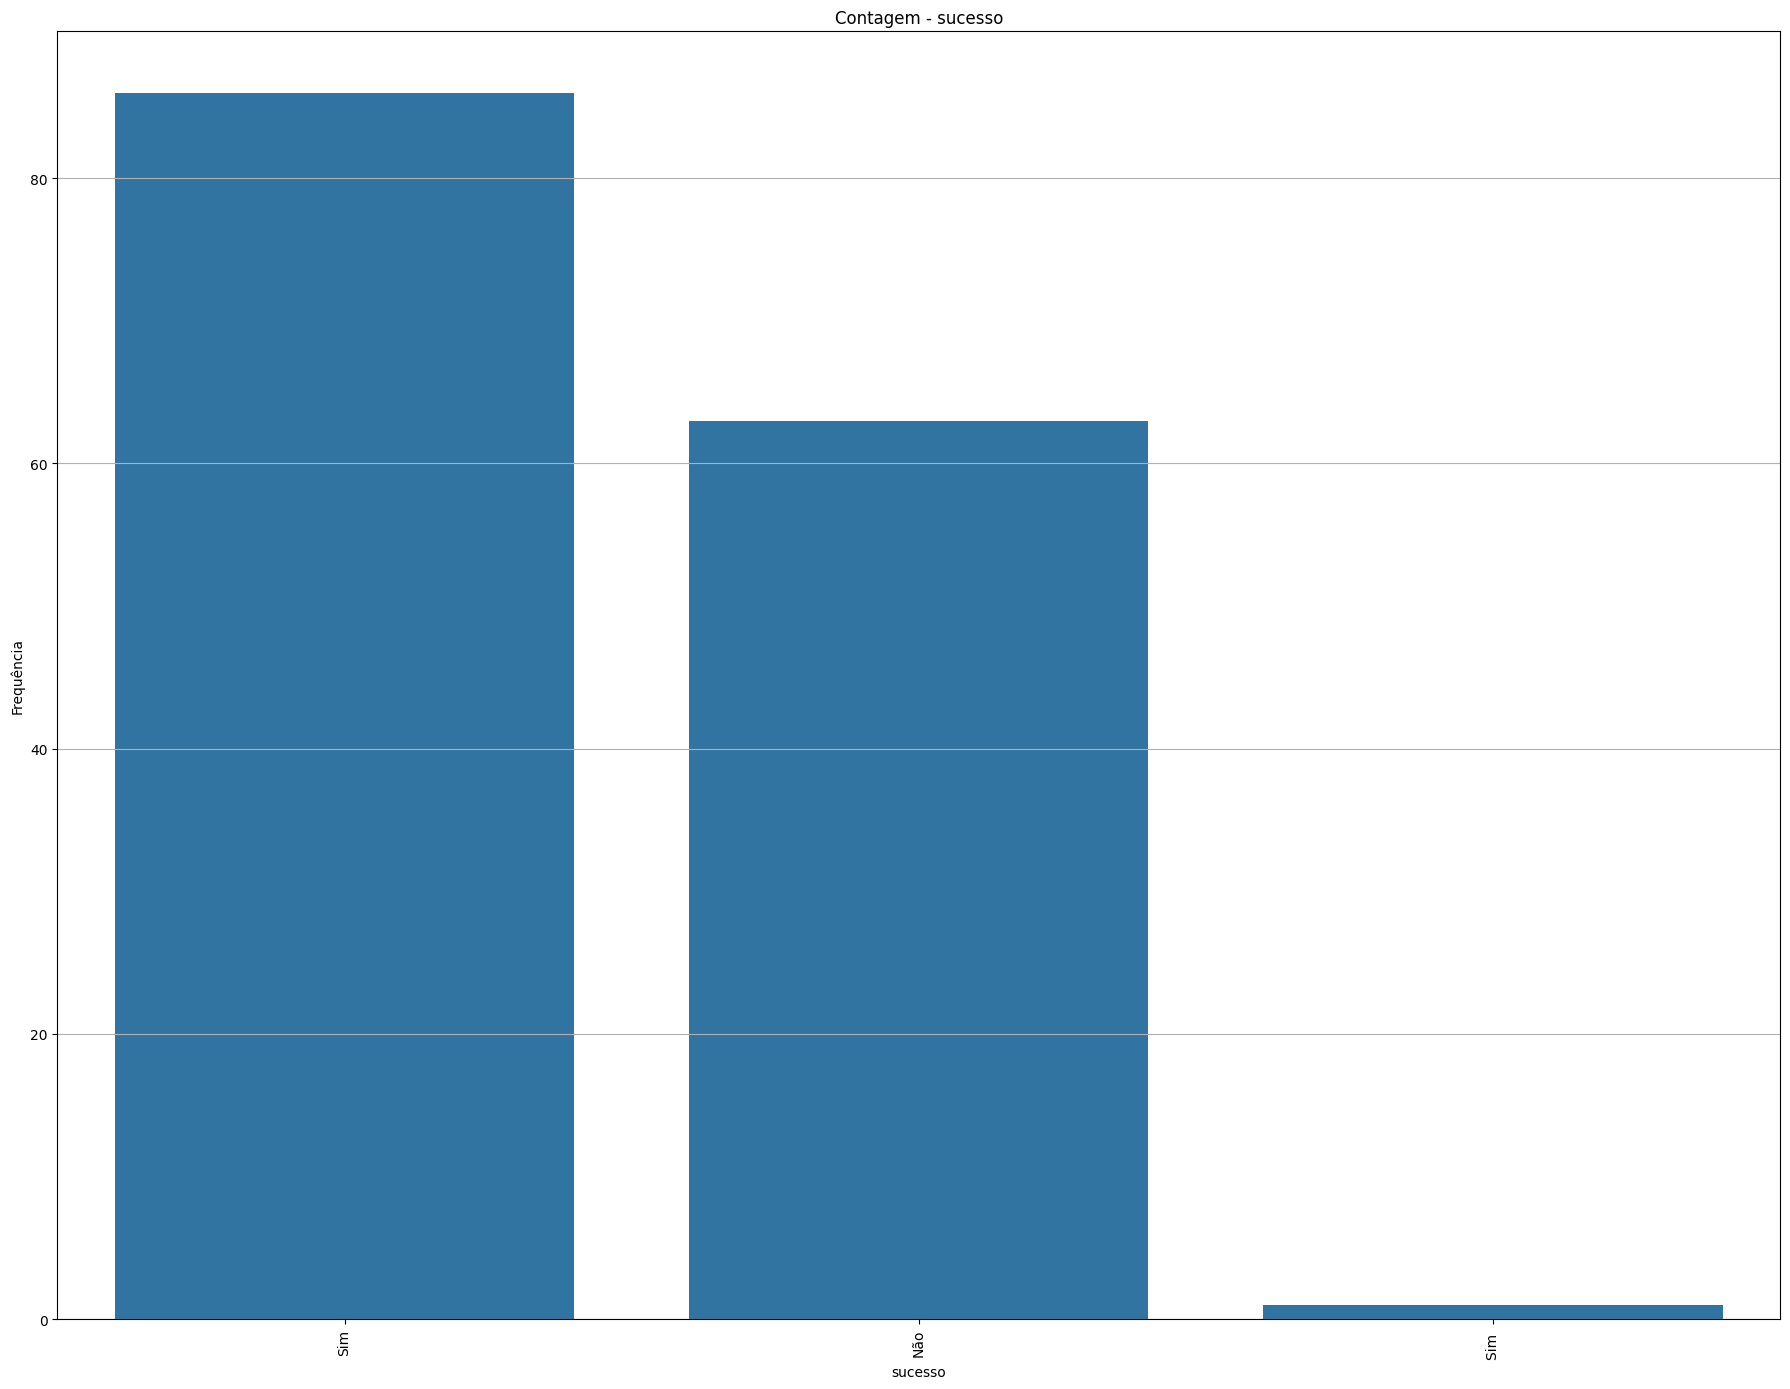

In [10]:
# Plotar contagem para variáveis categóricas
for col in cat_cols:
    plt.figure(figsize=(18, 14))
    sns.countplot(data=df_mkt, x=col, order=df_mkt[col].value_counts().index)
    plt.title(f'Contagem - {col}')
    plt.xlabel(col)
    plt.ylabel('Frequência')
    plt.xticks(rotation=90)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()


In [11]:
df_mkt.head()

,projeto,produto,tipo,tema,clima,investimento,alcance,engajamento,sentimento,edicao_repetida,resultado_anterior,inovacao,sucesso
0,Carnaval 2024,CARNA2024,Evento,Festivo,ensolarado,40000.0,15000.0,20000.000000,neutro,Sim,bom,2.0,Sim
1,Carnaval 2025,CARNA2025,Evento,Festivo,nublado,20000.0,30000.0,100000.000000,positivo,Sim,ruim,2.0,Não
2,Destino SC Verão 2025,DESTI2025,Turístico,Turismo,nublado,50000.0,20000.0,11097.959491,positivo,Sim,ruim,3.0,Sim
3,Destino de Inverno 2024,DESINV2024,Turístico,Turismo,frio,15000.0,10000.0,5952.031201,negativo,Sim,não se aplica,3.0,Sim
4,Em evidência,EVIDENCIA,Ativação,Diversidade,chuvoso,20000.0,20000.0,5607.226172,neutro,Sim,excelente,4.0,Sim


In [12]:
print(df_mkt.dtypes)

projeto                object
produto                object
tipo                   object
tema                   object
clima                  object
investimento          float64
alcance               float64
engajamento           float64
sentimento             object
edicao_repetida        object
resultado_anterior     object
inovacao              float64
sucesso                object
dtype: object


#### Tratando a variavel target

In [13]:
# Limpar a coluna, tirando espaços e transformando tudo em lowercase,
df_mkt['sucesso'] = df_mkt['sucesso'].astype(str).str.strip().str.lower()

In [14]:
# Trate a variável alvo antes do split
df_mkt['sucesso'] = df_mkt['sucesso'].astype(str).str.strip().str.lower()
df_mkt['sucesso'] = df_mkt['sucesso'].map({'sim': 1, 'não': 0})

In [15]:
print(df_mkt.dtypes)

projeto                object
produto                object
tipo                   object
tema                   object
clima                  object
investimento          float64
alcance               float64
engajamento           float64
sentimento             object
edicao_repetida        object
resultado_anterior     object
inovacao              float64
sucesso                 int64
dtype: object


#### Separação dos dados

In [16]:
df_train, df_test = train_test_split(df_mkt, test_size=0.2, random_state=42)

X_train = df_train.drop('sucesso', axis=1)
y_train = df_train['sucesso']

X_test = df_test.drop('sucesso', axis=1)
y_test = df_test['sucesso']


#### Pré-Processamento dos Dados

In [17]:
# One-Hot Encoding nos dados de treino e teste
X_train_enc = pd.get_dummies(X_train, drop_first=True)
X_test_enc = pd.get_dummies(X_test, drop_first=True)

# Alinhe as colunas do teste para ter as mesmas colunas do treino
X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)


#### Treinar o modelo

XGBoost

In [18]:
model = XGBClassifier(random_state=42)
model.fit(X_train_enc, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [19]:
# Fazer previsões
y_pred_xgb = model.predict(X_test_enc)
y_proba_xgb = model.predict_proba(X_test_enc)[:, 1]  # Probabilidade da classe positiva

In [20]:
# Métricas
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb))
print("Recall:", recall_score(y_test, y_pred_xgb))
print("F1 Score:", f1_score(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, y_proba_xgb))

Accuracy: 0.5666666666666667
Precision: 0.7692307692307693
Recall: 0.5
F1 Score: 0.6060606060606061
ROC AUC: 0.52


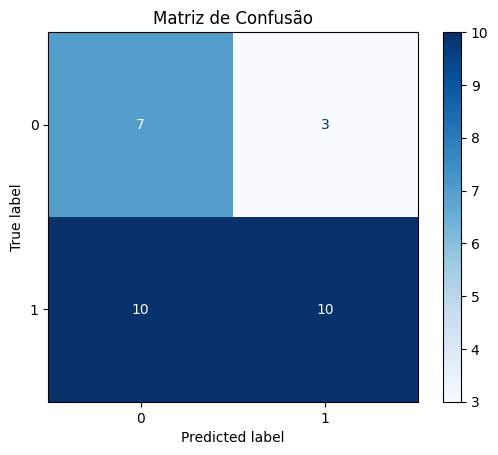

In [21]:
# Matriz de confusão
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão")
plt.show()

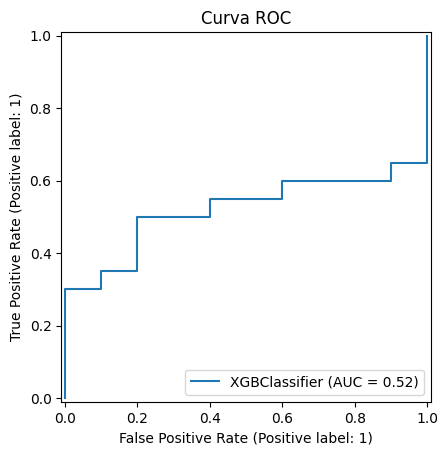

In [22]:
# Curva ROC
roc_disp = RocCurveDisplay.from_estimator(model, X_test_enc, y_test)
plt.title("Curva ROC")
plt.show()

Classe 1 está sendo melhor reconhecida
- Recall = 0.63: o modelo acerta 63% dos positivos reais.
- Precision = 0.61: dos que ele prevê como positivos, 61% são de fato verdadeiros.
Isso sugere que a classe 1 (sucesso = 1) está sendo melhor aprendida pelo modelo.

Acurácia próxima de aleatória (53%)
- Com duas classes, uma acurácia de ~50% indica que o modelo está quase "chutando".
- Porém, como o recall da classe 1 está acima de 0.6, há algum aprendizado acontecendo.

In [23]:
# Validação cruzada estratificada com 5 folds, só no treino
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [24]:

# Cross-validation com scoring F1 macro
scores = cross_val_score(model, X_train_enc, y_train, cv=cv, scoring='f1_macro')

# Mostrar resultados
print(f"F1 macro por fold: {scores}")
print(f"Média do F1 macro: {scores.mean():.4f}")

F1 macro por fold: [0.41666667 0.41258741 0.46666667 0.55555556 0.33333333]
Média do F1 macro: 0.4370


#### Regressão Logistica

In [25]:
# 1. Instanciando o modelo
logreg = LogisticRegression(max_iter=1000, random_state=42)

# 2. Treinando o modelo com os dados já codificados
logreg.fit(X_train_enc, y_train)

/home/josiele/Projeto Marketing/marketing-classification/mkt/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [26]:
# 3. Fazendo previsões
y_pred_rg = logreg.predict(X_test_enc)

# 4. Avaliando o modelo
print("Matriz de confusão:")
print(confusion_matrix(y_test, y_pred_rg))

print("\nRelatório de classificação:")
print(classification_report(y_test, y_pred_rg))

print("Acurácia:", accuracy_score(y_test, y_pred_rg))


Matriz de confusão:
[[ 3  7]
 [ 6 14]]

Relatório de classificação:
              precision    recall  f1-score   support

           0       0.33      0.30      0.32        10
           1       0.67      0.70      0.68        20

    accuracy                           0.57        30
   macro avg       0.50      0.50      0.50        30
weighted avg       0.56      0.57      0.56        30

Acurácia: 0.5666666666666667


#### Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Instanciar o modelo
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Treinar
rf.fit(X_train_enc, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [28]:
# Prever
y_pred_rf = rf.predict(X_test_enc)

# Avaliar
print("Matriz de confusão:")
print(confusion_matrix(y_test, y_pred_rf))

print("\nRelatório de classificação:")
print(classification_report(y_test, y_pred_rf))

print("Acurácia:", accuracy_score(y_test, y_pred_rf))


Matriz de confusão:
[[ 1  9]
 [ 5 15]]

Relatório de classificação:
              precision    recall  f1-score   support

           0       0.17      0.10      0.12        10
           1       0.62      0.75      0.68        20

    accuracy                           0.53        30
   macro avg       0.40      0.42      0.40        30
weighted avg       0.47      0.53      0.50        30

Acurácia: 0.5333333333333333


#### Track Experiments - MlFlow

In [29]:
import mlflow
import mlflow.sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# ====================== Configurações ======================
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("MarketingModels")

# ====================== 1. XGBoost ======================
acc_xgb = accuracy_score(y_test, y_pred_xgb)
prec_xgb = precision_score(y_test, y_pred_xgb)
rec_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
roc_xgb = roc_auc_score(y_test, y_proba_xgb)

with mlflow.start_run(run_name="XGBoost"):
    mlflow.log_param("model_type", "XGBClassifier")
    mlflow.log_param("random_state", 42)

    mlflow.log_metric("accuracy", acc_xgb)
    mlflow.log_metric("precision", prec_xgb)
    mlflow.log_metric("recall", rec_xgb)
    mlflow.log_metric("f1_score", f1_xgb)
    mlflow.log_metric("roc_auc", roc_xgb)

    mlflow.sklearn.log_model(model, "model")

# ====================== 2. Regressão Logística ======================
y_proba_rg = logreg.predict_proba(X_test_enc)[:, 1]

acc_rg = accuracy_score(y_test, y_pred_rg)
prec_rg = precision_score(y_test, y_pred_rg)
rec_rg = recall_score(y_test, y_pred_rg)
f1_rg = f1_score(y_test, y_pred_rg)
roc_rg = roc_auc_score(y_test, y_proba_rg)

with mlflow.start_run(run_name="Logistic Regression"):
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_param("random_state", 42)

    mlflow.log_metric("accuracy", acc_rg)
    mlflow.log_metric("precision", prec_rg)
    mlflow.log_metric("recall", rec_rg)
    mlflow.log_metric("f1_score", f1_rg)
    mlflow.log_metric("roc_auc", roc_rg)

    mlflow.sklearn.log_model(logreg, "model")

# ====================== 3. Random Forest ======================
y_proba_rf = rf.predict_proba(X_test_enc)[:, 1]

acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_rf = roc_auc_score(y_test, y_proba_rf)

with mlflow.start_run(run_name="Random Forest"):
    mlflow.log_param("model_type", "RandomForestClassifier")
    mlflow.log_param("random_state", 42)
    mlflow.log_param("n_estimators", 100)

    mlflow.log_metric("accuracy", acc_rf)
    mlflow.log_metric("precision", prec_rf)
    mlflow.log_metric("recall", rec_rf)
    mlflow.log_metric("f1_score", f1_rf)
    mlflow.log_metric("roc_auc", roc_rf)

    mlflow.sklearn.log_model(rf, "model")


2025/07/21 15:15:31 INFO mlflow.tracking.fluent: Experiment with name 'MarketingModels' does not exist. Creating a new experiment.
2025/07/21 15:15:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/21 15:15:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/21 15:15:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run XGBoost at: http://127.0.0.1:5000/#/experiments/698341802245143922/runs/241b64134c8b4f9581671756386d3f70
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/698341802245143922


2025/07/21 15:15:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/21 15:15:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run Logistic Regression at: http://127.0.0.1:5000/#/experiments/698341802245143922/runs/613e2d4135a94c1482b2ede106220815
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/698341802245143922


2025/07/21 15:15:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Random Forest at: http://127.0.0.1:5000/#/experiments/698341802245143922/runs/8e728956e7dc4f06a7412ddb8ec571b7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/698341802245143922


#### Insights

Média 0.5392 indica que o modelo não está generalizando muito bem, mas também não está completamente aleatório.
Pode estar sofrendo com:
- Poucos dados
-Muitas features (283 colunas)
- Dados desbalanceados

Classe 0 está com desempenho fraco
- Apenas 7 acertos (TP) de um total de 18.
- O modelo comete mais erros (11 falsos positivos) do que acertos.
Precision e recall abaixo de 0.4, o que indica baixa confiabilidade ao prever “insucesso”.

Eixo X (Falso Positivo Rate - FPR): Quanto o modelo erra dizendo que algo é positivo quando não é.

Eixo Y (Verdadeiro Positivo Rate - TPR / recall): Quanto o modelo acerta dizendo que algo é positivo quando realmente é.

Linha tracejada diagonal: É o desempenho de um modelo aleatório (AUC = 0.5).

Um AUC de 0.54 indica que seu modelo mal consegue distinguir entre as classes, estando muito próximo de um modelo aleatório. Isso está em linha com o F1 macro (~0.53) e reforça a necessidade de reduzir a dimensionalidade, reavaliar as variáveis e possivelmente testar outras abordagens de modelagem.